# Data download and processing

In [ ]:
from typing import Tuple
import os
from tqdm import tqdm
import cv2
import numpy as np

###############################
# Loading in data
###############################
def find_dir_within_path(path, dir_name):
  for root_path, list_of_dirs, list_of_files in os.walk(path):
    if dir_name in list_of_dirs:
      return str(os.path.join(root_path, dir_name))
  raise Exception(f'Directory {dir_name} not found under {path}')

def fetch_dataset_path(dataset_id):
  kaggle_path = '/kaggle/input/'
  try:
    import kagglehub
    dataset_path = os.path.join(kaggle_path, dataset_id)
    if not os.path.isdir(dataset_path):
      print('Downloading dataset')
      dataset_path = kagglehub.dataset_download(dataset_id)
  except ImportError:
    print("Could not import kagglehub")
    dataset_path = find_dir_within_path(os.getcwd(), dataset_id)
  return dataset_path
KAGGLE_DATASET_ID = 'andrewmvd/face-mask-detection'
dataset_path = fetch_dataset_path(KAGGLE_DATASET_ID)
os.listdir(dataset_path)

Using Colab cache for faster access to the 'face-mask-detection' dataset.


['annotations', 'images']

In [ ]:
ANNOTATIONS_PATH = os.path.join(dataset_path, 'annotations')
IMAGES_PATH = os.path.join(dataset_path, 'images')
paths_no_exists = []
CLASSES = set()
import xml.etree.ElementTree as ET
for anno_path in os.listdir(ANNOTATIONS_PATH):
  annotation_obj_list = ET.parse(os.path.join(ANNOTATIONS_PATH, anno_path)).findall('object')
  anno_names = [obj.find('name').text for obj in annotation_obj_list]
  CLASSES.update(anno_names)
  anno_name = anno_path.split('.')[0]
  exists = os.path.exists(os.path.join(IMAGES_PATH, f'{anno_name}.png'))
  if not exists:
    paths_no_exists.append(anno_name)
assert len(paths_no_exists) == 0, f'Found {len(paths_no_exists)} annotations without images'
print('All annotations have images')
print(f'Classes: {CLASSES}')


All annotations have images
Classes: {'with_mask', 'mask_weared_incorrect', 'without_mask'}


In [ ]:
import xml.etree.ElementTree as ET
sample_annotation = ET.parse(os.path.join(ANNOTATIONS_PATH, 'maksssksksss0.xml'))
root = sample_annotation.findall('object')
print(root[0].find('name').text)

without_mask


In [ ]:
import torchvision

import pandas as pd

import os
import xml.etree.ElementTree as ET
import torch
import torchvision

from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader

class Face_Mask_Dataset(torch.utils.data.Dataset):
    def __init__(self, image_path = IMAGES_PATH, annotation_path = ANNOTATIONS_PATH, classes = CLASSES, transforms=None):
        self.img_dir = image_path
        self.imgs = os.listdir(image_path)
        self.anno_dir = annotation_path
        self.transforms = transforms
        self.classes_dict = dict(zip(classes, range(len(classes))))

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        # Image
        image_name = self.imgs[idx]
        img_path = os.path.join(self.img_dir, image_name)
        if not os.path.exists(img_path):
          raise Exception(f'Image {image_name} does not exist')
        # Annotations
        anno_path = os.path.join(self.anno_dir, image_name.replace('.png', '.xml'))
        if not os.path.exists(anno_path):
          raise Exception(f'Annotation {anno_path} does not exist')
        image = Image.open(img_path).convert('RGB')
        tree = ET.parse(anno_path)
        boxes = []
        labels = []

        for object in tree.findall('object'):
            name = object.find('name').text
            bndbox = object.find('bndbox')
            xmin = int(bndbox.find('xmin').text)
            ymin = int(bndbox.find('ymin').text)
            xmax = int(bndbox.find('xmax').text)
            ymax = int(bndbox.find('ymax').text)
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(self.classes_dict[name])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {'boxes': boxes, 'labels':labels}
        if self.transforms is not None:
            image, target = self.transforms(image), target

        return image, target

In [ ]:
dataset = Face_Mask_Dataset(
    # transforms=torchvision.transforms.Compose([
    #   torchvision.transforms.ToTensor(),
    # ])
    )
dataset.__getitem__(0)

(<PIL.Image.Image image mode=RGB size=301x400>,
 {'boxes': tensor([[107., 277., 216., 400.]]), 'labels': tensor([1])})

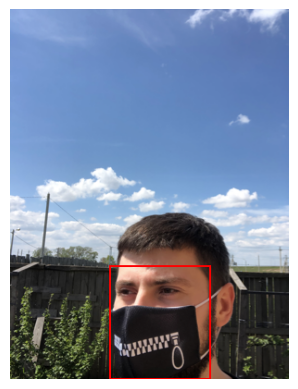

In [ ]:
import matplotlib.pyplot as plt
from PIL import ImageDraw

image, target = dataset.__getitem__(0)

# Create a drawing object
draw = ImageDraw.Draw(image)

# Iterate over each bounding box and draw it
for box in target['boxes']:
    xmin, ymin, xmax, ymax = box.tolist()
    # Draw a red rectangle (you can change color/width)
    draw.rectangle([xmin, ymin, xmax, ymax], outline="red", width=2)

plt.imshow(image)
plt.axis('off')
plt.show()

In [ ]:
import torch

# Define split ratios
total_size = len(full_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

# Set random seed for reproducibility
torch.manual_seed(42)

# Split the dataset
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    full_dataset, [train_size, val_size, test_size]
)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Testing dataset size: {len(test_dataset)}")

Training dataset size: 597
Validation dataset size: 127
Testing dataset size: 129


In [ ]:
full_dataset = Face_Mask_Dataset()
print(f"Full dataset created with {len(full_dataset)} images.")

Full dataset created with 853 images.


In [ ]:
import torch
from tqdm import tqdm
from PIL import Image
import numpy as np

class CroppedFaceDataset(torch.utils.data.Dataset):
    def __init__(self, face_mask_dataset_instance):
        self.face_mask_dataset = face_mask_dataset_instance
        self.cropped_data = []

        print("Processing Face Mask Dataset to extract cropped faces...")
        for i in tqdm(range(len(self.face_mask_dataset)), desc="Cropping faces"):
            image, target = self.face_mask_dataset[i]

            # Convert PIL Image to NumPy array for cropping
            image_np = np.array(image)

            boxes = target['boxes'].tolist() # Convert tensor to list of lists
            labels = target['labels'].tolist() # Convert tensor to list

            for box, label in zip(boxes, labels):
                xmin, ymin, xmax, ymax = map(int, box)

                # Ensure coordinates are within image bounds
                xmin = max(0, xmin)
                ymin = max(0, ymin)
                xmax = min(image_np.shape[1], xmax)
                ymax = min(image_np.shape[0], ymax)

                # Crop the face region
                cropped_face_np = image_np[ymin:ymax, xmin:xmax]

                # Convert cropped NumPy array back to PIL Image
                cropped_face_pil = Image.fromarray(cropped_face_np)

                self.cropped_data.append((cropped_face_pil, label))

        print(f"CroppedFaceDataset initialized with {len(self.cropped_data)} cropped faces.")

    def __len__(self):
        return len(self.cropped_data)

    def __getitem__(self, idx):
        return self.cropped_data[idx]

In [ ]:
cropped_dataset = CroppedFaceDataset(full_dataset)
print(f"Cropped dataset created with {len(cropped_dataset)} cropped faces.")

Processing Face Mask Dataset to extract cropped faces...


Cropping faces: 100%|██████████| 853/853 [00:21<00:00, 38.84it/s]

CroppedFaceDataset initialized with 4072 cropped faces.
Cropped dataset created with 4072 cropped faces.


In [ ]:
import torch

# Define split ratios
total_size = len(cropped_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

# Set random seed for reproducibility
torch.manual_seed(42)

# Split the dataset
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
    cropped_dataset, [train_size, val_size, test_size]
)

print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Testing dataset size: {len(test_dataset)}")

Training dataset size: 2850
Validation dataset size: 610
Testing dataset size: 612


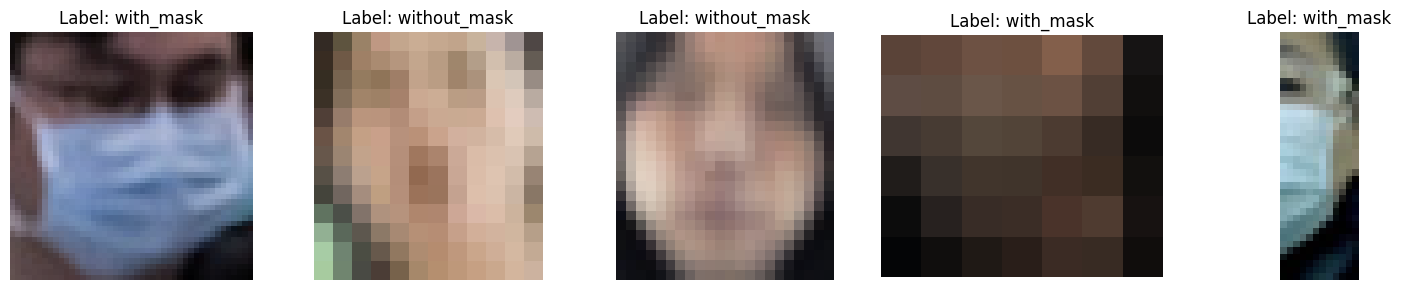

In [ ]:
import matplotlib.pyplot as plt
import random

num_examples = 5
fig, axes = plt.subplots(1, num_examples, figsize=(15, 3))

# Get class names from the original Face_Mask_Dataset for better readability
# Assuming CLASSES variable from earlier code contains the class names
class_names = list(CLASSES)
class_mapping = {v: k for k, v in dataset.classes_dict.items()}

for i in range(num_examples):
    random_index = random.randint(0, len(cropped_dataset) - 1)
    cropped_image, label_idx = cropped_dataset[random_index]

    axes[i].imshow(cropped_image)
    axes[i].set_title(f'Label: {class_mapping[label_idx]}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()
